In [36]:
import findspark
findspark.init()

In [37]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("pyspark-df-overview").getOrCreate()

In [38]:
spark.version

'3.4.1'

In [39]:
df = spark.read.csv("dataset/pyspark-df-overview/census_income.csv.gz", header=True)
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: string (nullable = true)
 |-- education: string (nullable = true)
 |-- education.num: string (nullable = true)
 |-- marital.status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital.gain: string (nullable = true)
 |-- capital.loss: string (nullable = true)
 |-- hours.per.week: string (nullable = true)
 |-- native.country: string (nullable = true)
 |-- income: string (nullable = true)



In [40]:
import pyspark.sql.types as t

census_schema = t.StructType([
      t.StructField('age', t.IntegerType(), True)
    , t.StructField('workclass', t.StringType(), True)
    , t.StructField('fnlwgt', t.IntegerType(), True)
    , t.StructField('education', t.StringType(), True)
    , t.StructField('education-num', t.IntegerType(), True)
    , t.StructField('marital-status', t.StringType(), True)
    , t.StructField('occupation', t.StringType(), True)
    , t.StructField('relationship', t.StringType(), True)
    , t.StructField('race', t.StringType(), True)
    , t.StructField('sex', t.StringType(), True)
    , t.StructField('capital-gain', t.DoubleType(), True)
    , t.StructField('capital-loss', t.DoubleType(), True)
    , t.StructField('hours-per-week', t.IntegerType(), True)
    , t.StructField('native-country', t.StringType(), True)
    , t.StructField('label', t.StringType(), True)
])

In [41]:
# Support for compressed (gziped) payload
df = spark.read.csv("dataset/pyspark-df-overview/census_income.csv.gz", header=True, schema=census_schema)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: double (nullable = true)
 |-- capital-loss: double (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- label: string (nullable = true)



In [42]:
df.count()

32561

In [43]:
df = df.drop('fnlwgt')
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: double (nullable = true)
 |-- capital-loss: double (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- label: string (nullable = true)



In [44]:
from pyspark.sql.functions import count, avg, desc

df.groupBy(['education']). \
agg(
    count('*').alias('qty'), 
    avg('age').alias('avg_age')
).orderBy(desc('qty')). \
show()

+------------+-----+------------------+
|   education|  qty|           avg_age|
+------------+-----+------------------+
|     HS-grad|10501|38.974478621083705|
|Some-college| 7291| 35.75627485941572|
|   Bachelors| 5355| 38.90494864612511|
|     Masters| 1723| 44.04991294254208|
|   Assoc-voc| 1382| 38.55354558610709|
|        11th| 1175| 32.35574468085106|
|  Assoc-acdm| 1067|37.381443298969074|
|        10th|  933| 37.42979635584137|
|     7th-8th|  646| 48.44582043343653|
| Prof-school|  576| 44.74652777777778|
|         9th|  514| 41.06031128404669|
|        12th|  433|              32.0|
|   Doctorate|  413| 47.70217917675545|
|     5th-6th|  333|42.885885885885884|
|     1st-4th|  168|46.142857142857146|
|   Preschool|   51| 42.76470588235294|
+------------+-----+------------------+



In [45]:
df.createOrReplaceTempView("census")
s = spark.sql("""
SELECT 
    education, 
    COUNT(*) AS qty, 
    AVG(age) AS avg_age
FROM census
GROUP BY education
""")
s.show()

+------------+-----+------------------+
|   education|  qty|           avg_age|
+------------+-----+------------------+
|        10th|  933| 37.42979635584137|
|     Masters| 1723| 44.04991294254208|
|     5th-6th|  333|42.885885885885884|
|  Assoc-acdm| 1067|37.381443298969074|
|   Assoc-voc| 1382| 38.55354558610709|
|     7th-8th|  646| 48.44582043343653|
|         9th|  514| 41.06031128404669|
|     HS-grad|10501|38.974478621083705|
|   Bachelors| 5355| 38.90494864612511|
|        11th| 1175| 32.35574468085106|
|     1st-4th|  168|46.142857142857146|
|   Preschool|   51| 42.76470588235294|
|        12th|  433|              32.0|
|   Doctorate|  413| 47.70217917675545|
|Some-college| 7291| 35.75627485941572|
| Prof-school|  576| 44.74652777777778|
+------------+-----+------------------+



In [46]:
# a transformation can be exposed as function
def my_query(field):
    return df.groupBy([field]). \
    agg(
        count('*').alias('qty'), 
        avg('age').alias('avg_age')
    ).orderBy(desc('qty'))
    
print(my_query('workclass').show())

+----------------+-----+------------------+
|       workclass|  qty|           avg_age|
+----------------+-----+------------------+
|         Private|22696|36.797585477617204|
|Self-emp-not-inc| 2541| 44.96969696969697|
|       Local-gov| 2093| 41.75107501194458|
|            null| 1836|40.960239651416124|
|       State-gov| 1298| 39.43605546995377|
|    Self-emp-inc| 1116| 46.01702508960574|
|     Federal-gov|  960|         42.590625|
|     Without-pay|   14|47.785714285714285|
|    Never-worked|    7|20.571428571428573|
+----------------+-----+------------------+

None


In [47]:
df.select('age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week').describe().show()

+-------+------------------+-----------------+------------------+-----------------+------------------+
|summary|               age|    education-num|      capital-gain|     capital-loss|    hours-per-week|
+-------+------------------+-----------------+------------------+-----------------+------------------+
|  count|             32561|            32561|             32561|            32561|             32276|
|   mean| 38.58164675532078| 10.0806793403151|1077.6488437087312|  87.303829734959|40.441318626843476|
| stddev|13.640432553581295|2.572720332067391| 7385.292084840311|402.9602186489979|12.401756275364061|
|    min|                17|                1|               0.0|              0.0|                 1|
|    max|                90|               16|           99999.0|           4356.0|                99|
+-------+------------------+-----------------+------------------+-----------------+------------------+



23/09/30 10:41:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: age, education.num, capital.gain, capital.loss, hours.per.week
 Schema: age, education-num, capital-gain, capital-loss, hours-per-week
Expected: education-num but found: education.num
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


In [48]:
df.select('workclass', 'education', 'marital-status').describe().show()

23/09/30 10:41:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: workclass, education, marital.status
 Schema: workclass, education, marital-status
Expected: marital-status but found: marital.status
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


+-------+-----------+------------+--------------+
|summary|  workclass|   education|marital-status|
+-------+-----------+------------+--------------+
|  count|      30725|       32561|         32561|
|   mean|       null|        null|          null|
| stddev|       null|        null|          null|
|    min|Federal-gov|        10th|      Divorced|
|    max|Without-pay|Some-college|       Widowed|
+-------+-----------+------------+--------------+



In [51]:
df.freqItems(['marital-status']).show(truncate=False)

+-----------------------------------------------------------------------------------------------------------+
|marital-status_freqItems                                                                                   |
+-----------------------------------------------------------------------------------------------------------+
|[Never-married, Divorced, Married-civ-spouse, Separated, Widowed, Married-AF-spouse, Married-spouse-absent]|
+-----------------------------------------------------------------------------------------------------------+



23/09/30 10:42:46 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: marital.status
 Schema: marital-status
Expected: marital-status but found: marital.status
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


In [21]:
df.groupby('native-country').agg({'native-country': 'count'}).sort('count(native-country)').show()

+--------------------+---------------------+
|      native-country|count(native-country)|
+--------------------+---------------------+
|                null|                    0|
|  Holand-Netherlands|                    1|
|            Scotland|                   12|
|            Honduras|                   13|
|             Hungary|                   13|
|Outlying-US(Guam-...|                   14|
|          Yugoslavia|                   16|
|                Laos|                   18|
|            Thailand|                   18|
|            Cambodia|                   19|
|     Trinadad&Tobago|                   19|
|                Hong|                   20|
|             Ireland|                   24|
|             Ecuador|                   28|
|              France|                   29|
|              Greece|                   29|
|                Peru|                   31|
|           Nicaragua|                   34|
|            Portugal|                   37|
|         

23/09/30 10:40:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: native.country
 Schema: native-country
Expected: native-country but found: native.country
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


In [58]:
from pyspark.sql.functions import isnan, when, count, col

# All columns
# cols = df.columns
# Selected columns
cols = ['workclass', 'education-num', 'occupation', 'hours-per-week', 'native-country']

# https://stackoverflow.com/a/44631639/570393
# counting the number of NaN or null values in each specified column.
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()

23/09/30 10:49:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: workclass, education.num, occupation, hours.per.week, native.country
 Schema: workclass, education-num, occupation, hours-per-week, native-country
Expected: education-num but found: education.num
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


+---------+-------------+----------+--------------+--------------+
|workclass|education-num|occupation|hours-per-week|native-country|
+---------+-------------+----------+--------------+--------------+
|     1836|            0|      1843|           285|           583|
+---------+-------------+----------+--------------+--------------+



In [56]:
# Total rows
print('total rows: %s' % df.count())

# After droping NA records
print('only complete rows: %s' % df.dropna().count())

total rows: 32561
only complete rows: 29900


23/09/30 10:48:37 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: age, workclass, education, education.num, marital.status, occupation, relationship, race, sex, capital.gain, capital.loss, hours.per.week, native.country, income
 Schema: age, workclass, education, education-num, marital-status, occupation, relationship, race, sex, capital-gain, capital-loss, hours-per-week, native-country, label
Expected: education-num but found: education.num
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


In [63]:
def show_df(df, field='occupation'):
    df.groupBy(field).count().show()

In [64]:
show_df(df)

+-----------------+-----+
|       occupation|count|
+-----------------+-----+
|            Sales| 3650|
|  Exec-managerial| 4066|
|   Prof-specialty| 4140|
|Handlers-cleaners| 1370|
|             null| 1843|
|  Farming-fishing|  994|
|     Craft-repair| 4099|
| Transport-moving| 1597|
|  Priv-house-serv|  149|
|  Protective-serv|  649|
|    Other-service| 3295|
|     Tech-support|  928|
|Machine-op-inspct| 2002|
|     Armed-Forces|    9|
|     Adm-clerical| 3770|
+-----------------+-----+



In [26]:
# Fill with a fixed value
new_df = df.fillna({'occupation': 'Other-service'})
# Count 
show_df(new_df)

+-----------------+-----+
|       occupation|count|
+-----------------+-----+
|            Sales| 3650|
|  Exec-managerial| 4066|
|   Prof-specialty| 4140|
|Handlers-cleaners| 1370|
|  Farming-fishing|  994|
|     Craft-repair| 4099|
| Transport-moving| 1597|
|  Priv-house-serv|  149|
|  Protective-serv|  649|
|    Other-service| 5138|
|     Tech-support|  928|
|Machine-op-inspct| 2002|
|     Armed-Forces|    9|
|     Adm-clerical| 3770|
+-----------------+-----+



In [27]:
from pyspark.sql.functions import mean
df.groupBy().agg(mean('hours-per-week').alias('hours-per-week')).show()

+------------------+
|    hours-per-week|
+------------------+
|40.441318626843476|
+------------------+



23/09/30 10:40:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: hours.per.week
 Schema: hours-per-week
Expected: hours-per-week but found: hours.per.week
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


In [73]:
df.groupBy('hours-per-week').mean().show()

23/09/30 10:54:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: age, education.num, capital.gain, capital.loss, hours.per.week
 Schema: age, education-num, capital-gain, capital-loss, hours-per-week
Expected: education-num but found: education.num
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


+--------------+------------------+------------------+------------------+------------------+-------------------+
|hours-per-week|          avg(age)|avg(education-num)| avg(capital-gain)| avg(capital-loss)|avg(hours-per-week)|
+--------------+------------------+------------------+------------------+------------------+-------------------+
|            31|              47.8|               8.6|             519.4|               0.0|               31.0|
|            85| 41.15384615384615| 9.307692307692308|               0.0|               0.0|               85.0|
|            65|39.290983606557376|10.774590163934427| 4611.602459016393|129.27868852459017|               65.0|
|            53|             38.48|              9.12|            440.52|               0.0|               53.0|
|            78|             38.25|               9.5|               0.0|               0.0|               78.0|
|            34|45.214285714285715| 8.535714285714286| 732.0357142857143| 72.92857142857143|    

In [28]:
from pyspark.sql.functions import mean
import pandas as pd

data_to_fill = \
    df.groupBy().agg(mean('hours-per-week').alias('hours-per-week')).toPandas().to_dict('records')[0]

# Simple Python Dict Update
data_to_fill.update({'occupation': 'Other-service'})

data_to_fill

23/09/30 10:40:04 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: hours.per.week
 Schema: hours-per-week
Expected: hours-per-week but found: hours.per.week
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


{'hours-per-week': 40.441318626843476, 'occupation': 'Other-service'}

In [29]:
df.fillna(data_to_fill).select('hours-per-week', 'occupation').show(50)

+--------------+-----------------+
|hours-per-week|       occupation|
+--------------+-----------------+
|            40|    Other-service|
|            18|  Exec-managerial|
|            40|    Other-service|
|            40|Machine-op-inspct|
|            40|   Prof-specialty|
|            45|    Other-service|
|            40|     Adm-clerical|
|            20|   Prof-specialty|
|            40|   Prof-specialty|
|            60|     Craft-repair|
|            35|   Prof-specialty|
|            45|   Prof-specialty|
|            20|    Other-service|
|            55|  Exec-managerial|
|            40|    Other-service|
|            40|   Prof-specialty|
|            76| Transport-moving|
|            50|  Exec-managerial|
|            40|Handlers-cleaners|
|            50|            Sales|
|            40|  Exec-managerial|
|            42|            Sales|
|            25|            Sales|
|            40| Transport-moving|
|            32|    Other-service|
|            40|    

23/09/30 10:40:05 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: occupation, hours.per.week
 Schema: occupation, hours-per-week
Expected: hours-per-week but found: hours.per.week
CSV file: file:///Users/pame/Documents/GitHub/alto-academy-part3-class2-big-data/Pyspark/dataset/pyspark-df-overview/census_income.csv.gz


In [30]:
# This is distributed
df_spark = df.groupBy('workclass').agg(count('*').alias('counts')).orderBy('counts')
# df_spark.show()

# This is running on driver
df_wk = df_spark.toPandas()

In [31]:
# Check Pandas DF content
df_wk

,workclass,counts
0,Never-worked,7
1,Without-pay,14
2,Federal-gov,960
3,Self-emp-inc,1116
4,State-gov,1298
5,None,1836
6,Local-gov,2093
7,Self-emp-not-inc,2541
8,Private,22696


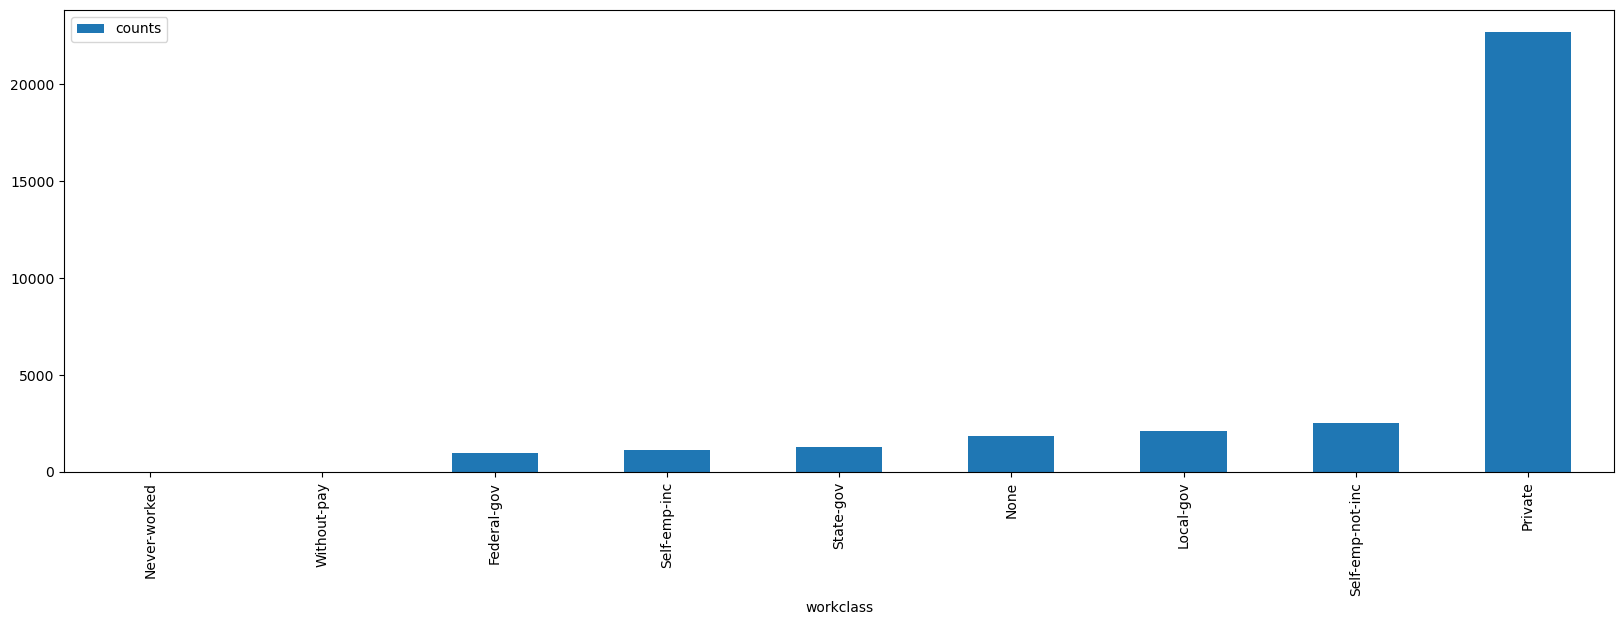

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

df_wk.plot.bar(x='workclass', y='counts', figsize=(20,6));

In [33]:
spark.stop()